# Popis naslova

* ## Opis dokumenta
    * ### Tema dokumenta
    * ### Što je SSK
    * ### Rad SVM i SSK zajedno

* ## Opis našeg rada
    * ### Unos podataka
    * ### Filtriranje podataka
    * ### Priprema podataka
    * ### Treniranje
    * ### Testiranje
    * ### Analiza rezultata


### Klasifikacija Teksta Korištenjem Jezgri Nad Nizovima

- **Korištenje Specijaliziranog Kernela**: Razvijen je novi pristup za kategorizaciju tekstova koristeći kernel baziran na svim podnizovima duljine 'k'.
- **Eksponencijalni Težinski Faktori**: Podnizovi su vagani s faktorima koji eksponencijalno opadaju ovisno o njihovoj kontinuitetu unutar teksta.
- **Primjena Dinamičkog Programiranja**: Uprkos visokoj dimenzionalnosti prostora značajki, unutarnji produkt se efikasno računa pomoću dinamičkog programiranja.
- **Usporedba s Standardnim Pristupima**: Kernel se empirijski uspoređuje s tradicionalnim jezgrama temeljenima na riječima, pokazujući bolje rezultate na određenim skupovima podataka.
- **Aproksimacija za Velike Skupove Podataka**: Predložena je tehnika aproksimacije koja omogućava efikasnu obradu velikih skupova podataka bez značajnog gubitka informacija.


### String Subsequence Kernel (SSK)

- **Definicija SSK**: String Subsequence Kernel je posebna vrsta jezgre koja mjeri sličnost između tekstualnih dokumenata na temelju zajedničkih podnizova znakova.
- **Podnizovi znakova**: SSK uzima u obzir sve moguće podnizove duljine 'k' unutar teksta, ne zahtijevajući da su znakovi podnizova uzastopni.
- **Težinska funkcija**: SSK primjenjuje eksponencijalno opadajuću težinsku funkciju na podnizove, dajući veću važnost onima koji su prostorno bliži unutar teksta.
- **Efikasnost izračuna**: Zbog velike dimenzionalnosti prostora značajki, SSK koristi tehnike dinamičkog programiranja kako bi izračunao jezgre brzo i učinkovito.
- **Primjena u kategorizaciji teksta**: SSK se uspješno koristi u zadacima kategorizacije teksta, gdje se pokazao boljim u odnosu na standardne pristupe bazirane na frekvenciji riječi.


### Rad SVM i SSK Zajedno

- **Integracija SVM i SSK**: Support Vector Machines (SVM) se koriste u kombinaciji s String Subsequence Kernelom (SSK) za klasifikaciju tekstualnih podataka.
- **Prednosti SSK u SVM**: SSK omogućava SVM-u da efikasno obrađuje tekst tako što identificira složene obrasce u podacima koristeći podnizove znakova.
- **Visokodimenzionalni Prostori**: SSK prenosi tekst u visokodimenzionalni prostor značajki koji SVM može koristiti za razlikovanje kategorija.
- **Dinamičko Programiranje**: Korištenje dinamičkog programiranja unutar SSK-a smanjuje vremensku složenost izračuna potrebnih za SVM.
- **Poboljšanje Klasifikacije**: Kombinacija SVM-a s SSK-om pokazuje bolje rezultate u klasifikaciji teksta u odnosu na tradicionalne metode klasifikacije.


#






# Opis našeg rada

## Unos podataka

In [70]:
import os

from bs4 import BeautifulSoup

# Define the directory where your files are located
directory = 'dataset/reuters21578/'

# Set of desired topics
desired_topics = {'earn', 'acq', 'crude', 'corn'}

# Function to extract topics and body content from a Reuters entry
def extract_topics_and_body(reuter):
    # First find the TOPICS tag
    topics_tag = reuter.find('topics')
    # Then find all D tags within the TOPICS tag
    topics = [topic.text for topic in topics_tag.find_all('d')] if topics_tag else []
    body = reuter.find('body')
    body_content = body.text if body else None

    # Keep only the desired topics, if there is exactly one match
    matched_topics = [topic for topic in topics if topic in desired_topics]

    if len(matched_topics) == 1:
        # Return the single matched topic and the body content
        return matched_topics[0], body_content
    else:
        # Return None to indicate no topic or multiple topics found
        return None, None

# List to hold all articles from all files
all_articles = []

# Counter for 'earn' topics
earn_counter = 0
acq_counter = 0
crude_counter = 0

# Process the first N files
for i in range(10):
    filename = f'reut2-00{i}.sgm' if i < 10 else f'reut2-0{i}.sgm'
    file_path = os.path.join(directory, filename)

    # Open and parse the file
    with open(file_path, 'r', encoding='latin1') as file:
        parsed_content = BeautifulSoup(file.read(), 'html.parser')

        # Extract information from each Reuters entry
        for reuter in parsed_content.find_all('reuters'):
            topic, body_content = extract_topics_and_body(reuter)

            # Continue to the next iteration if body_content is empty or None
            if not body_content:
                continue

            all_articles.append({'topic': topic, 'body': body_content})


#
## Filtriranje podataka

In [ ]:
from collections import Counter

# Initialize a counter for all topics
topics_counter = Counter()

#model_articles = all_articles
model_articles = []

for topic in desired_topics:
    # Filter articles by topic and slice the first 30
    articles_of_topic = [article for article in all_articles if article['topic'] == topic][:60]
    # Extend the model_articles list with the filtered articles
    model_articles.extend(articles_of_topic)

# Iterate over each article and update the count of the topic
for article in model_articles:
    # The topic is now a string, not a list, so we increment its count by 1
    topics_counter[article['topic']] += 1

# Now we have a counter object with all topics and their counts
# Let's convert it to a list of (topic, count) pairs for easier viewing
topics_count_list = topics_counter.most_common()


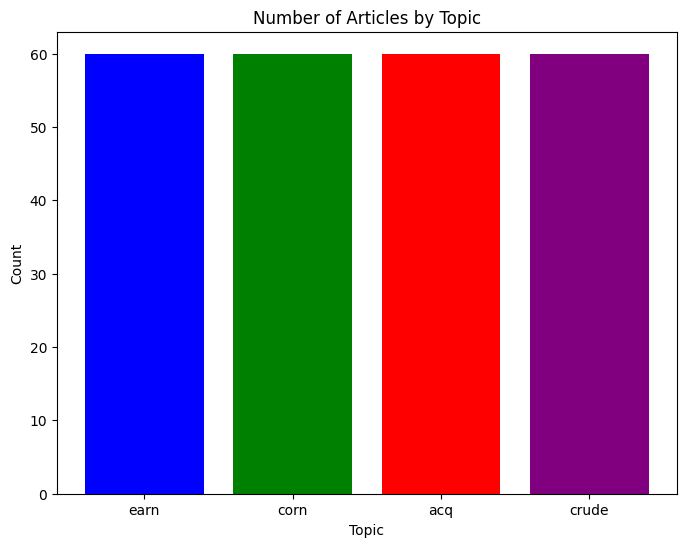

In [102]:
import matplotlib.pyplot as plt

# Data from the image
topics = []
counts = []
for topic, count in topics_count_list:
    topics.append(topic)
    counts.append(count)

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(topics, counts, color=['blue', 'green', 'red', 'purple'])

# Add titles and labels
plt.title('Number of Articles by Topic')
plt.xlabel('Topic')
plt.ylabel('Count')

# Show the graph
plt.show()


#
## Priprema podataka za test

In [103]:
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the set of stop words the first time
nltk.download('punkt')
nltk.download('stopwords')

# Load stop words
stop_words = set(stopwords.words('english'))

# Define a function to clean the text
def clean_text(text):
    # Tokenize the text to words
    words = word_tokenize(text)
    # Remove punctuation and convert to lower case
    words = [word.lower() for word in words if word.isalpha()]
    # Remove stop words
    words = [word for word in words if not word in stop_words]
    # Join words back to string
    text = ' '.join(words)
    return text

# Split your articles into the text content and labels
X = [clean_text(article['body']) for article in model_articles]  # list of text contents
y = [article['topic'] for article in model_articles]  # list of corresponding labels

# Since the SSK kernel expects the input as arrays of strings, we need to reshape our data
# Convert the lists to numpy arrays and reshape them to be 2D with one column
import numpy as np
X = np.array(X).reshape(-1, 1)  # Text data
y = np.array(y)  # Labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=40, train_size=160, random_state=40)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lkrcelic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lkrcelic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


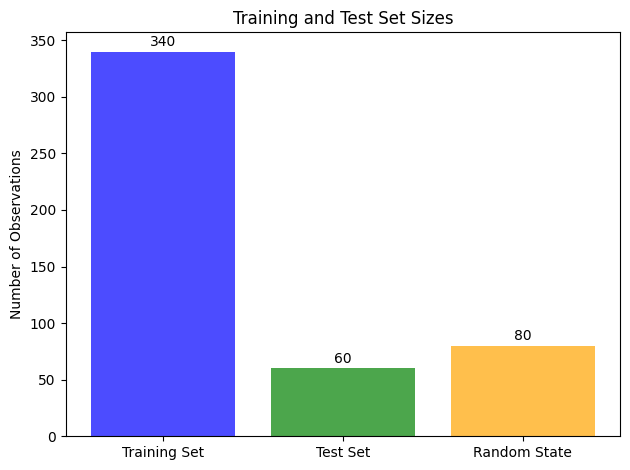

In [104]:
import matplotlib.pyplot as plt

# Placeholder values for the size of each set
train_size = 340
test_size = 60
random_state = 80

# Assuming that the total size is the sum of train and test
total_size = train_size + test_size + random_state

# Define the labels, positions, and sizes for the bars
labels = ['Training Set', 'Test Set', 'Random State']
sizes = [train_size, test_size, random_state]
positions = range(len(labels))

# Create the bar chart
plt.bar(positions, sizes, align='center', alpha=0.7, color=['blue', 'green', 'orange'])

# Add the counts above the bars
for i in range(len(labels)):
    plt.text(i, sizes[i] + total_size*0.01, str(sizes[i]), ha='center')

# Add some text for labels, title, and axes ticks
plt.ylabel('Number of Observations')
plt.title('Training and Test Set Sizes')

# Add the labels to the x-axis at bar centers
plt.xticks(positions, labels)

plt.tight_layout()
plt.show()


#
## Treniranje

In [ ]:
from sklearn.svm import SVC
from string_kernel import string_kernel

# Define the SSK kernel parameters
max_substring = 3
lambda_decay = 0.8

def get_ssk_kernel_for_scikit(max_substring, lambda_decay):
    def ssk_kernel(X, Y):
        if X.ndim < 2:
            X = np.array(X).reshape(-1, 1)
        if Y.ndim < 2:
            Y = np.array(Y).reshape(-1, 1)

        return string_kernel(X, Y, max_substring, float(lambda_decay))
    return ssk_kernel

# Create the custom SSK kernel function for scikit-learn
my_ssk_kernel = get_ssk_kernel_for_scikit(max_substring, lambda_decay)

# Create the SVM classifier using the custom kernel
clf = SVC(kernel=my_ssk_kernel)

# Train the SVM classifier
clf.fit(X_train, y_train)


#
## Testiranje

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test data
y_pred = clf.predict(X_test)


#
## Analiza rezultata

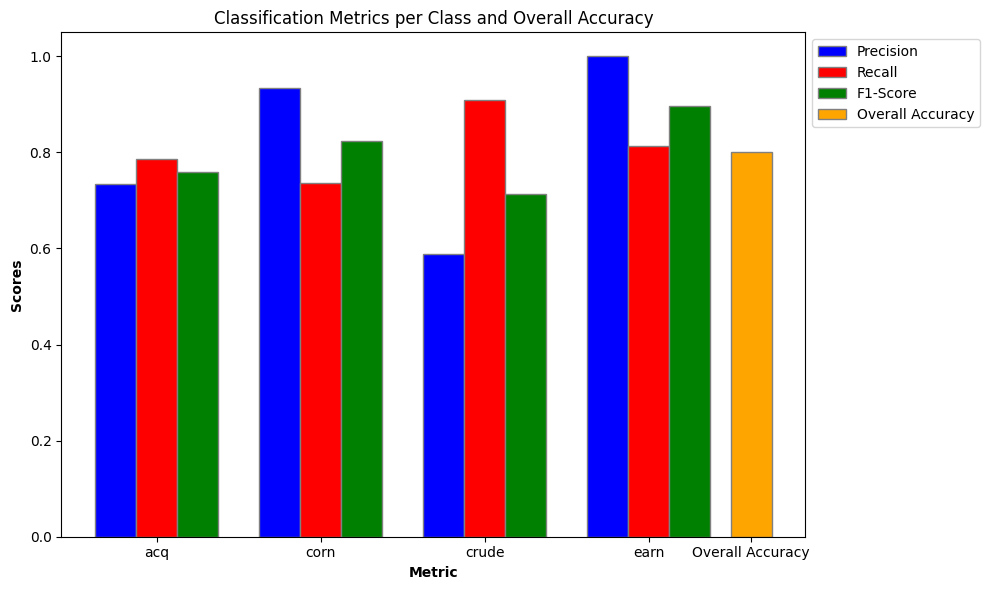

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score


report = classification_report(y_test, y_pred, output_dict=True)

labels = ['acq', 'corn', 'crude', 'earn']
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

overallAccuracy = accuracy_score(y_test, y_pred)

bar_width = 0.25

# Positions for the first three sets of bars (precision, recall, f1-score)
r1 = np.arange(len(precision))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the plot
plt.figure(figsize=(10, 6))

plt.bar(r1, precision, color='blue', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='red', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='green', width=bar_width, edgecolor='grey', label='F1-Score')

# Plotting the overall accuracy separately on the far right
overall_accuracy_bar_pos = r3[-1] + 1.5 * bar_width  # Adjust the 1.5 if needed
plt.bar(overall_accuracy_bar_pos, overallAccuracy, color='orange', width=bar_width, edgecolor='grey', label='Overall Accuracy')

# Add xticks on the middle of the group bars and for the overall accuracy
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(precision))] + [overall_accuracy_bar_pos], labels + ['Overall Accuracy'])

# Create legend & Show graphic
plt.title('Classification Metrics per Class and Overall Accuracy')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))  # Place legend outside to the top
plt.tight_layout()
plt.show()
